In [1]:
# import required packages
# source: https://www.kaggle.com/allunia/patterns-of-colorectal-cancer-wally

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='darkgrid')

# Import classifiers used:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier

# Data Transformation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer


# Import ovo and ovr related stuff
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import VotingClassifier

# Pre-processing Data:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict, GridSearchCV, KFold

# Import Metrics
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve, classification_report, multilabel_confusion_matrix, confusion_matrix, plot_confusion_matrix, plot_roc_curve, precision_score, recall_score

# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import kerastuner as kt
from tensorflow import keras

#Base Libraries
import random

# Custom Transformer for Y
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import TransformedTargetRegressor

from tqdm import tqdm_notebook

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [2]:
# Ensure that GPU is detected
assert(tf.config.experimental.list_physical_devices('GPU') is not None), 'GPU not detected'
print('GPU Detected. TF good to go')

GPU Detected. TF good to go


### Read Data from CSV File & Do Preprocessing required

In [3]:
df = pd.read_csv('../01_Data_Files/hmnist_64_64_L.csv', engine='c') # read 64x64 gray scale images as csv
dict_class_names = {1: 'Tumor', 2:'Stroma', 3:'Complex', 4:'Lymphoma', 5:'Debris', 6:'Mucosa', 7:'Adipose', 8:'Empty'}

# Adds a column with name of the label based on the integer value
df['label_name'] = df['label'].map(dict_class_names)

# 
class_names = ['Tumor', 'Stroma', 'Complex', 'Lymphoma', 'Debris', 'Mucosa', 'Adipose', 'Empty']

In [4]:
X = df.drop(['label', 'label_name'], axis=1).values
y = df.loc[:, 'label_name'].values.reshape(-1,1)

assert len(X) == len(y), 'X & y length mismatch'

### Use MinMax Scaler to scale the values of X from 0-255 to between 0 and 1. 

The min max scaler uses the following formula to calculate the scaled values:

$$ x^{\prime} = \frac{x-min(x)}{max(x)-min(x)}$$

In [5]:
# Scale Values of X via a MinMaxScaler
# We know that our input can vary between 0 and 255
min_max_scaler = MinMaxScaler()

# Create a fake array with values between 0 and 255 to use for fitting min max scaler
scaling_array = np.append(
    [np.zeros_like(X[0], dtype=np.int16)], [np.full_like(X[0], 255, dtype=np.int16)], axis=0
)
min_max_scaler.fit(scaling_array)
X_scaled = min_max_scaler.transform(X)

### One Hot Encode Y values for Tensorflow Usage & Label Encode for Sklearn Usage

To learn more about one hot encoding:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?highlight=one%20hot%20encode#sklearn.preprocessing.OneHotEncoder

To learn more about label encoding:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html?highlight=encoder#sklearn.preprocessing.LabelEncoder




In [6]:
# One Hot Encode y_values:
one_hot_encoder = OneHotEncoder(sparse=False)
y_one_hot = one_hot_encoder.fit_transform(y)
print('One Hot Encoded Y Shape: ', y_one_hot.shape)

# Label Encoding to conver String labels to integer labels:
label_encoder = LabelEncoder()
y_int_encode = label_encoder.fit_transform(y)
print(f'Label Encoded Y Shape: {y_int_encode.shape}, Max Value: {y_int_encode.max()}, Min Value: {y_int_encode.min()}')

One Hot Encoded Y Shape:  (5000, 8)
Label Encoded Y Shape: (5000,), Max Value: 7, Min Value: 0


In [7]:
# Lets make sure that that distribution of our data hasn't changed significantly due to scaling. 
# Mostly a sanity check
# fig, axs = plt.subplots(4, 4, figsize=(22,27))
# for i in range(4):

#     # Show Original Images
#     original_image = np.reshape(X_scaled[i], (64,64))
#     axs[0,i].imshow(original_image, cmap='gray')
#     label_image = y[i]
#     axs[0,i].set_title(f'Original Image: {label_image}')
#     axs[0,i].grid(False)

#     # Show histogram of values in image:
#     sns.distplot(original_image, ax=axs[1,i])
#     axs[1,i].set_title('Original Image Distribution')
#     axs[1,i].set_ylabel('')

#     # Show Scaled Images:
#     scaled_image = np.reshape(X_scaled[i], (64,64))
#     axs[2,i].imshow(scaled_image, cmap='gray')
#     label_image = y[i]
#     axs[2,i].set_title(f'MinMax Scaled Image: {label_image}')
#     axs[2,i].grid(False)

#     # Show histogram of values in image:
#     sns.distplot(scaled_image, ax=axs[3,i])
#     axs[3,i].set_title('MinMax Image Distribution')
#     axs[3,i].set_ylabel('')

# plt.savefig('Image Distributions.png')


### Setup Nested CV

Nested CV allows us to do both hyper parameter tuning and classifier performance comparision without producing an overly-optimistic score as in the case of non-nested CV. This happens when information leaks into the model since we use the same data to not only do hyper paramter tuning but also evaluation. 

We will use evolutionary algorithms to find the best parameters instead of relying on grid search. This is done in the interest of time. 

##### Parameters for each model:

Create a parameter grid for evolutionary search: 
The structure of the grid wil be: {clf_name:{param_name:value, param_name:value}, clf_name:{param_name:value...}}

Nested dictionaries!

In [8]:
# Convolutional Neural Network:
# Architecture: Input - Conv2D, Conv 2D, Conv2D, Flatten, Dense, Dense, Dense - Output
# Source: https://www.kaggle.com/efeergun96/colorectal-histology-prediction-by-cnn
def create_model(hp):
    model = Sequential()

    model.add(Reshape(
        target_shape= (64,64,1), 
        input_shape = (4096,),
    ))

    model.add(Conv2D(
        filters = 128, 
        kernel_size = (5,5), 
        padding = 'same',
        activation = 'relu' 
    ))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        activation='relu'
    ))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        activation='relu'
    ))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dense(8, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate= hp_learning_rate) , loss = "categorical_crossentropy", metrics=["accuracy"])
    return model

In [9]:
param_grid = {}
param_grid['k_neighbors_clf'] = {'n_neighbors':np.linspace(3, 20, num=3,dtype=np.int),
                                'weights':['distance'],
                                'leaf_size': np.linspace(10, 30, num=3, dtype=np.int),
                                'p':[1]}

param_grid['gaussianb_clf'] = {'var_smoothing':[1e-9]}
param_grid['svm_clf_ovr']  = {  'C'     : np.logspace(-5, 3, num=4, base=10),
                            'gamma' : np.logspace(-9, 3, num=4, base=10), 
                            'kernel': ['rbf'],
                            'random_state':[42],
                            'decision_function_shape':['ovr']}

param_grid['random_forest_clf'] = {
    'n_estimators':[20,100,200],
    'random_state':[42]
}

param_grid['dummy_clf'] = {'strategy': ['stratified'],
                            'random_state':[42]}

random.seed(42)

In [35]:
k_neighbors_clf = KNeighborsClassifier()
gaussianb_clf = GaussianNB()

svm_clf_ovr = svm.SVC()

from sklearn.ensemble import RandomForestClassifier

random_forest_clf = RandomForestClassifier()

# Used for a baseline. 
dummy_clf = DummyClassifier()

tuner = kt.Hyperband(create_model, 
                                    objective= 'val_accuracy',
                                    max_epochs=20,
                                    factor=3,
                                    directory = 'keras-model-logs',
                                    project_name = 'ece740-project1'
                                    )

# Dictionary of all classifiers
clfs = {
    'tuner':tuner,
    'k_neighbors_clf' : k_neighbors_clf,
    'gaussianb_clf' : gaussianb_clf,
    'svm_clf_ovr' : svm_clf_ovr,
    'random_forest_clf' : random_forest_clf,
    'dummy_clf': dummy_clf 
}

scoring = {
    'acc':'accuracy',
    'prec_macro':'precision_macro',
    'rec_macro':'recall_macro',
    'f1_macro':'f1_macro',
}

def custom_scorer(y_true, y_pred, score_dict):
    if not score_dict:
        score_dict['test_acc'] = []
        score_dict['test_prec_macro'] = []
        score_dict['test_rec_macro'] = []
        score_dict['test_f1_macro'] = []
    
    score_dict['test_acc'].append(accuracy_score(y_true, y_pred))
    score_dict['test_prec_macro'].append(precision_score(y_true, y_pred, average='macro'))
    score_dict['test_rec_macro'].append(recall_score(y_true, y_pred, average='macro'))
    score_dict['test_f1_macro'].append(f1_score(y_true, y_pred, average='macro'))



INFO:tensorflow:Reloading Oracle from existing project keras-model-logs/ece740-project1/oracle.json
INFO:tensorflow:Reloading Tuner from keras-model-logs/ece740-project1/tuner0.json


In [11]:
# Dictionary will contain scores for each of the 
RANDOM_SEED = 42

nested_scores = {}
non_nested_scores = {}
# Using F1-macro since we have a balanced data set. 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

for key, value in clfs.items():
    print(f'Fitting and testing {key} classifier')
    outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

    # Formats the label (y) as either integer encoding or one-hot encoding for non-cnn clfs 
    # and cnn-clfs accordingly. 
    if key == 'tuner':
        y_current = y_one_hot
        n_jobs_param = 1

        nested_scores[key] = {}

        for train_idx, test_idx in tqdm_notebook(outer_cv.split(X_scaled, y_int_encode)):
            # create fake training target with integer encode to be used for inner split. SKFold does not like one-hot-encoded labels. 
            fake_train_target_ = y_int_encode[train_idx]
            
            train_data, test_data = X_scaled[train_idx], X_scaled[test_idx]
            train_target, test_target = y_current[train_idx], y_current[test_idx]

            # Do parameter tuning with validation/inner cv. 

            for i, (train_idx_inner, val_idx) in tqdm_notebook(enumerate(inner_cv.split(train_data, fake_train_target_))):
                train_data_inner, validate_data = train_data[train_idx_inner], train_data[val_idx]
                train_target_inner, validate_target = train_target[train_idx_inner], train_target[val_idx]

                value.search(train_data_inner, train_target_inner, epochs=20, validation_data = (validate_data, validate_target))


            best_hps = value.get_best_hyperparameters(num_trials = 1)[0]
            best_model = value.get_best_models(num_models=1)[0]

            history = best_model.fit(train_data, train_target, epochs=20, verbose=1, validation_split=0.1)

            predictions = best_model.predict(test_data)

            predictions = one_hot_encoder.inverse_transform(predictions)
            test_target_oh = one_hot_encoder.inverse_transform(test_target)

            # Do testing & append scores
            custom_scorer(test_target_oh, predictions, nested_scores[key])
    
    
    else:
        y_current = y_int_encode
        n_jobs_param = -1

        clf = GridSearchCV(estimator=value, 
                        param_grid=param_grid[key], 
                        scoring='f1_macro',
                        cv=inner_cv, 
                        n_jobs=n_jobs_param,
                        verbose=2,
                        refit=True)

        clf.fit(X_scaled, y_current)

        print(f'Parameter Optimization Complete for {key}, best params: \n{clf.best_params_}')
        nested_scores[key] = cross_validate(
            clf,
            X=X_scaled,
            y=y_current,
            scoring=scoring,
            cv=outer_cv,
            n_jobs=n_jobs_param,
            verbose=2,
        )

        print(f'Testing complete for {key}, results:')
        print(nested_scores[key])

Fitting and testing tuner classifier


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit

Epoch 1/20
94/94 [==============================] - 1s 11ms/step - loss: 0.9330 - accuracy: 0.6095 - val_loss: 2.0995 - val_accuracy: 0.0000e+00
Epoch 2/20
94/94 [==============================] - 1s 8ms/step - loss: 0.8667 - accuracy: 0.6349 - val_loss: 2.4217 - val_accuracy: 0.0000e+00
Epoch 3/20
94/94 [==============================] - 1s 8ms/step - loss: 0.9099 - accuracy: 0.6152 - val_loss: 2.3045 - val_accuracy: 0.0060
Epoch 4/20
94/94 [==============================] - 1s 8ms/step - loss: 0.8098 - accuracy: 0.6639 - val_loss: 2.3692 - val_accuracy: 0.0060
Epoch 5/20
94/94 [==============================] - 1s 8ms/step - loss: 0.8231 - accuracy: 0.6599 - val_loss: 2.6247 - val_accuracy: 0.0000e+00
Epoch 6/20
94/94 [==============================] - 1s 8ms/step - loss: 0.7702 - accuracy: 0.6702 - val_loss: 2.5188 - val_accuracy: 0.0000e+00
Epoch 7/20
94/94 [==========

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit

Epoch 1/20
94/94 [==============================] - 1s 10ms/step - loss: 0.9578 - accuracy: 0.5855 - val_loss: 2.4211 - val_accuracy: 0.0000e+00
Epoch 2/20
94/94 [==============================] - 1s 9ms/step - loss: 0.8844 - accuracy: 0.6322 - val_loss: 2.8878 - val_accuracy: 0.0000e+00
Epoch 3/20
94/94 [==============================] - 1s 8ms/step - loss: 0.8453 - accuracy: 0.6562 - val_loss: 2.4230 - val_accuracy: 0.0000e+00
Epoch 4/20
94/94 [==============================] - 1s 8ms/step - loss: 0.8004 - accuracy: 0.6766 - val_loss: 2.6578 - val_accuracy: 0.0000e+00
Epoch 5/20
94/94 [==============================] - 1s 9ms/step - loss: 0.7750 - accuracy: 0.6799 - val_loss: 2.2010 - val_accuracy: 0.0000e+00
Epoch 6/20
94/94 [==============================] - 1s 9ms/step - loss: 0.8440 - accuracy: 0.6405 - val_loss: 2.8121 - val_accuracy: 0.0000e+00
Epoch 7/20
94/94 [==

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit

Epoch 1/20
94/94 [==============================] - 1s 10ms/step - loss: 1.0317 - accuracy: 0.5603 - val_loss: 1.9985 - val_accuracy: 0.0030
Epoch 2/20
94/94 [==============================] - 1s 8ms/step - loss: 0.9275 - accuracy: 0.5923 - val_loss: 2.5130 - val_accuracy: 0.0000e+00
Epoch 3/20
94/94 [==============================] - 1s 8ms/step - loss: 0.8099 - accuracy: 0.6483 - val_loss: 2.8343 - val_accuracy: 0.0000e+00
Epoch 4/20
94/94 [==============================] - 1s 9ms/step - loss: 0.8266 - accuracy: 0.6413 - val_loss: 2.7203 - val_accuracy: 0.0000e+00
Epoch 5/20
94/94 [==============================] - 1s 9ms/step - loss: 0.7864 - accuracy: 0.6583 - val_loss: 2.7701 - val_accuracy: 0.0000e+00
Epoch 6/20
94/94 [==============================] - 1s 8ms/step - loss: 0.7438 - accuracy: 0.6857 - val_loss: 2.9229 - val_accuracy: 0.0000e+00
Epoch 7/20
94/94 [======

In [13]:
df_scores = pd.DataFrame(nested_scores)
df_scores.to_csv('nest_scores.csv')

In [36]:
acc_list = []
prec_list = []
recall_list = []
f1_list = []
classifier_list = []
for key,value in nested_scores_modified.items():
    classifier_list.append(key)
    classifier_list.append(key)
    classifier_list.append(key)

    acc_list.extend(value['test_acc'])
    prec_list.extend(value['test_prec_macro'])
    recall_list.extend(value['test_rec_macro'])
    f1_list.extend(value['test_f1_macro'])

df_scores = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1', 'Classifier'])
df_scores['Accuracy'] = acc_list
df_scores['Precision'] = prec_list
df_scores['Recall'] = recall_list
df_scores['F1'] = f1_list
df_scores['Classifier'] = classifier_list

In [37]:
df_scores

,Accuracy,Precision,Recall,F1,Classifier
0,0.406119,0.613239,0.406250,0.347026,knn
1,0.398920,0.565140,0.398808,0.347583,knn
2,0.417767,0.568896,0.417824,0.372030,knn
3,0.573485,0.577599,0.573760,0.571462,gnb
4,0.568086,0.569855,0.567874,0.564109,gnb
5,0.603241,0.613507,0.603049,0.599349,gnb
6,0.584283,0.587388,0.584468,0.582940,svm_ovr
7,0.584883,0.591485,0.584822,0.584732,svm_ovr
8,0.599640,0.601613,0.599507,0.597956,svm_ovr
9,0.704859,0.732323,0.704732,0.684695,cnn


In [59]:
df_scores_grouped = df_scores.groupby('Classifier')

In [49]:
df_scores_aggregate = df_scores_grouped.agg([np.mean, np.std])

In [85]:
df_scores_grouped.get_group('dummy')['Accuracy']

15    0.124775
16    0.123575
17    0.114046
Name: Accuracy, dtype: float64

In [54]:
df_scores_aggregate.to_csv('aggregate_scores.csv')

In [60]:
df_score_mean = df_scores_grouped.mean()
df_score_std = df_scores_grouped.std()

array(['cnn', 'dummy', 'gnb', 'knn', 'random_forest_clf', 'svm_ovr'],
      dtype=object)

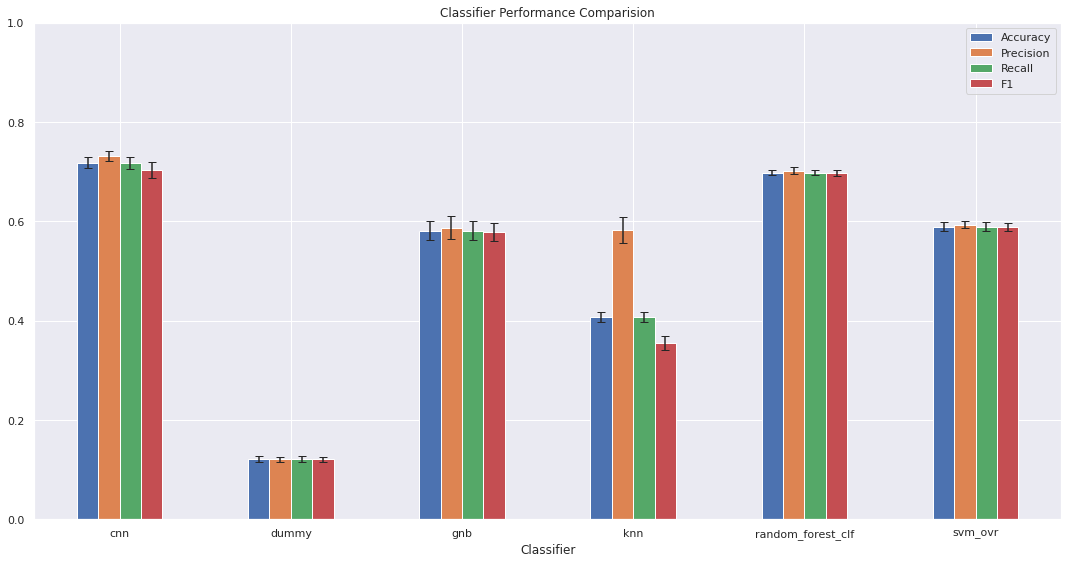

In [82]:
fig, ax = plt.subplots(figsize=(15,8))
df_score_mean.plot.bar(yerr=df_score_std, ax=ax, rot=0, capsize=4, ylim=(0,1))
plt.title('Classifier Performance Comparision')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Classifier-Score-Bar-Plot.png')

In [88]:
# Modified Paired T-Test
# https://medium.com/analytics-vidhya/using-the-corrected-paired-students-t-test-for-comparing-the-performance-of-machine-learning-dc6529eaa97f

diff = [y - x for y,x in zip(df_scores_grouped.get_group('cnn')['F1'], df_scores_grouped.get_group('svm_ovr')['F1'])]
d_bar = np.mean(diff)
sigma = np.var(diff)
n1 = 5000*0.8
n2 = 5000*0.2
n = 5000

sigma_mod = sigma * (1/n + n2/n1)

t_statistic = d_bar / np.sqrt(sigma_mod)

from scipy.stats import t

Pvalue = ((1-t.cdf(t_statistic, n-1)) * 200)

0.0

In [90]:
cnn_final = clfs['tuner'].get_best_models(num_models=1)[0]
random_forest_final = RandomForestClassifier(n_estimators=200, random_state=42)

Epoch 1/5
32/32 [==============================] - 1s 33ms/step - loss: 0.1088 - accuracy: 0.9710 - val_loss: 3.9302 - val_accuracy: 0.4986
Epoch 2/5
32/32 [==============================] - 1s 30ms/step - loss: 0.0328 - accuracy: 0.9900 - val_loss: 3.2280 - val_accuracy: 0.4994
Epoch 3/5
32/32 [==============================] - 1s 29ms/step - loss: 0.0240 - accuracy: 0.9900 - val_loss: 4.0679 - val_accuracy: 0.5011
Epoch 4/5
32/32 [==============================] - 1s 30ms/step - loss: 0.0088 - accuracy: 0.9960 - val_loss: 3.8101 - val_accuracy: 0.5054
Epoch 5/5
32/32 [==============================] - 1s 30ms/step - loss: 0.0092 - accuracy: 0.9970 - val_loss: 4.0799 - val_accuracy: 0.4959


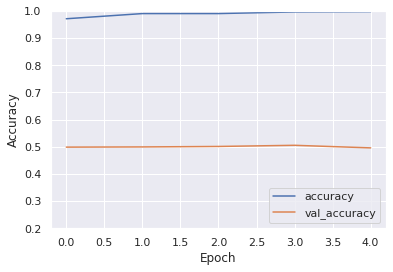

In [99]:
history = cnn_final.fit(X_scaled, y_one_hot, validation_split=0.8, epochs=5, )

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

In [ ]:
random_forest_final.fit(X_scaled, y_int_encode)